# Bayes Naive

## Introduccion

En este trabajo practico el objetivo es predecir el story point (grado de complejidad) de un sotry user.

## Importaciones

### Instalaciones previas

In [1]:
# !pip install stop_words

### Bibliotecas

In [63]:
# Generales
import pandas as pd
import numpy as np

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Importar / Exportar
import joblib
from joblib import load

# Procesamiento
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

# Vecorizadores
from sklearn.feature_extraction.text import TfidfVectorizer

# Bayes
from sklearn.naive_bayes import BernoulliNB
from scipy.stats import uniform, randint

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV

# Voting
from sklearn.ensemble import VotingClassifier

# Bibliotecas que sirven para lematizar
import stop_words
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, make_scorer

import joblib

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV

import spacy

### Datastes

In [3]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words_en = stop_words.get_stop_words('en')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Exploracion


### Exploracion del dataset de entrenamiento

In [5]:
df_train.head(10)

,id,title,description,project,storypoint
0,5660,Error enabling Appcelerator services during ap...,"When creating the default app, I encountered t...",project8,3
1,9014,Create a maintenance branch,"As a developer, I'd like to have a maintenance...",project6,5
2,4094,Service Activity Monitoring Backend integrated...,SAM API used by SAM GUI,project1,5
3,811,fs::enter(rootfs) does not work if 'rootfs' is...,I noticed this when I was testing the unified ...,project5,2
4,4459,transform processor with script option is broken,Creating the following stream throws exception...,project6,2
5,8896,Service Registry: REST endpoints URL renaming,Endpoint URLs of Service Registry REST service...,project1,1
6,2304,TiStudio: Projects - A pane is missing when cr...,Details: If you try to create the default Tita...,project8,5
7,9192,Avoid installing test and performance services...,The membership plans are associated with organ...,project8,5
8,1888,Add Unit Tests for CC SPI infrastructure,"Test Converter, Configuration, Definition and ...",project6,3
9,4609,Agent should not return partial state when a r...,Currently when a user is hitting /state.json o...,project5,3


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7900 entries, 0 to 7899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7900 non-null   int64 
 1   title        7900 non-null   object
 2   description  7900 non-null   object
 3   project      7900 non-null   object
 4   storypoint   7900 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 308.7+ KB


Cantidad de filas

In [7]:
filas, columnas = df_train.shape
print(f"Cantidad de user stories: {filas}")
print(f"Cantidad de features: {columnas}")

Cantidad de user stories: 7900
Cantidad de features: 5


In [8]:
columns_train = df_train.columns
columns_train

Index(['id', 'title', 'description', 'project', 'storypoint'], dtype='object')

Nos fijamos si existen valores nulos en el dataframe

In [9]:
cantidad_nulos_train = df_train.isnull().sum()
print(f"Valores nulos por columna:\n{cantidad_nulos_train}")

Valores nulos por columna:
id             0
title          0
description    0
project        0
storypoint     0
dtype: int64


Nos fijamos si existen valores Nan los en el dataframe

In [10]:
print(df_train.isna().sum())

id             0
title          0
description    0
project        0
storypoint     0
dtype: int64


In [11]:
print(df_train.isna().any().any())

False


In [12]:
valores_unicos = df_train["storypoint"].unique()
print(f"Valores unicos encontrados de sotry points: {valores_unicos}")

Valores unicos encontrados de sotry points: [ 3  5  2  1  8 13  4 40  6 20 10 15 32 12 16 21 34 14 24  7]


Observacion:
*   Nuestro dataset esta disponible para poder transformar directamente a vectores sin necesidad de mayores transformacion.


Pero por si acaso se eliminan

In [13]:
df_train.dropna(subset=["description", "storypoint"], inplace=True)

In [86]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7900 entries, 0 to 7899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           7900 non-null   int64 
 1   title        7900 non-null   object
 2   description  7900 non-null   object
 3   project      7900 non-null   object
 4   storypoint   7900 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 308.7+ KB


### Exploracion del dataset de test

In [14]:
df_test.head(10)

,id,title,description,project
0,3433,Add Run > Tizen Emulator menu action in App an...,The action will create the launch shortcut for...,project8
1,106,Chrome & IE mis-behavior,"On Wed, Aug 4, 2010 at 12:21 PM, Bryan Beecher...",project2
2,7182,Problems with Publishing routes (on release re...,I have a problem with publishing routes in Nex...,project1
3,8985,Redis sink: better handling of module options/...,Please see the discussion here: https://githu...,project6
4,2149,java0.log generated by the SAM,"I found an issue on the TAC 5.2.1, a java0.log...",project1
5,7150,Modularize XD UI,From https://jira.springsource.org/browse/XD-1...,project6
6,9326,BPM Connector: in case Authorization allow emp...,"- Configure WS Connector to use Authorization,...",project1
7,6162,Add Documentation for Nvidia GPU support,https://reviews.apache.org/r/46220/,project5
8,2008,create.sql in add-ons/sam/db won't work with A...,"Activating the sam-server-war in Tomcat, using...",project1
9,568,Docker provisioner store should reuse existing...,"Currently, the docker provisioner store will d...",project5


Se observa que efectivamente no tiene la variable dependiente/target storypoint. Este dataset sera usado para que una vez que tengamos el modelo entrenado, poder predecir ir armar un archivo `.csv` con las columnas `id` y `storypoint` (predicha) para subir a la competencia de Kaggle.

In [85]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1975 non-null   int64 
 1   title        1975 non-null   object
 2   description  1975 non-null   object
 3   project      1975 non-null   object
dtypes: int64(1), object(3)
memory usage: 61.8+ KB


In [15]:
columns_test = df_test.columns
columns_test

Index(['id', 'title', 'description', 'project'], dtype='object')

In [16]:
cantidad_nulos = df_test.isnull().sum()
print(f"Valores nulos por columna:\n{cantidad_nulos}")

Valores nulos por columna:
id             0
title          0
description    0
project        0
dtype: int64


In [17]:
print(df_test.isna().sum())

id             0
title          0
description    0
project        0
dtype: int64


In [18]:
print(df_test.isna().any().any())

False


## Preprocesamiento

---------------------
* Tokenizacion  
  * Operacion de separar el texto en unidades basicas(tokens).
  * Existen varias fuentes de variaciones segun el idioma.
    * Normalizacion.
    * Expreciones regulares.
    * SPACY (lematiza, excluye stop words)
  * Tokenizacion a nivel oracion(sentences) o a nivel palabras(words)
* Corpus de texto
* Bolsa de palabras (BoW - Bag of Words)
  * Counter Vectorizer
  * TF-IDF
  * N-gramas
  * Stop Words --> Palabras que no aportan informacion. Depende de cada idioma.
  * Stemming
  * Lemmatizacion


> FIT y Transform solo para entrenamiento.
>
> Transform para Test

---------------------

Primero nos guardamos una copia original de los datasets

In [19]:
df_train_original = df_train.copy()
df_test_original = df_test.copy()

### Lemmatizacion

Impacto de la lematización:

* Reduce dimensionalidad y ruido al unificar formas flexionadas.
* Mejora la generalización del modelo, aunque puede eliminar información contextual.

Hiperparámetros ajustados:

* max_features: Número máximo de características.
* ngram_range: Tipo de n-gramas utilizados (unigramas, bigramas).
* min_df y max_df: Controlan la frecuencia mínima/máxima de las palabras en el corpus.

In [20]:
# Cargar el modelo de spaCy para lematización en inglés
nlp = spacy.load("en_core_web_sm")

In [21]:
# Función para aplicar lematización
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

#### Separacion del dataset de train para entrenar modelo

Para realizar varias pruebas se propone aramar varios datasets segun los siguiente criterios:
* El dataset original.
* Sumar la informacion del titulo a la descripcion de la user story.

In [22]:
X_original = df_train_original["description"]
y_original = df_train_original["storypoint"]

In [23]:
X_original.head()

,description
0,"When creating the default app, I encountered t..."
1,"As a developer, I'd like to have a maintenance..."
2,SAM API used by SAM GUI
3,I noticed this when I was testing the unified ...
4,Creating the following stream throws exception...


In [24]:
y_original.head()

,storypoint
0,3
1,5
2,5
3,2
4,2


##### Teniendo en cuenta el titulo

Nos creamos un dataset teniendo en cuenta el titulo a partir del original

In [25]:
df_train_with_title = df_train.copy()
df_test_with_title = df_test.copy()

Tener en cuenta la informacion del titulo podria sumar informacion

In [26]:
df_train_with_title['text'] = df_train_with_title['title'] + " " + df_train_with_title['description']
df_test_with_title['text'] = df_test_with_title['title'] + " " + df_test_with_title['description']

`X` sin lemmatizar

In [27]:
df_train_with_title["text"].head()

,text
0,Error enabling Appcelerator services during ap...
1,"Create a maintenance branch As a developer, I'..."
2,Service Activity Monitoring Backend integrated...
3,fs::enter(rootfs) does not work if 'rootfs' is...
4,transform processor with script option is brok...


`y`  sin lemmatizar

In [28]:
df_train_with_title["storypoint"].head()

,storypoint
0,3
1,5
2,5
3,2
4,2


In [29]:
df_train_with_title['text'] = df_train_with_title['text'].apply(lemmatize_text)
df_test_with_title['text'] = df_test_with_title['text'].apply(lemmatize_text)

In [30]:
X_with_title = df_train_with_title["text"]
y_with_title = df_train_with_title["storypoint"]

In [31]:
X_with_title.head()

,text
0,error enable Appcelerator service app creation...
1,create maintenance branch developer like maint...
2,service Activity Monitoring Backend integrate ...
3,fs::enter(rootfs work rootfs read notice test ...
4,transform processor script option break create...


In [32]:
y_with_title.head()

,storypoint
0,3
1,5
2,5
3,2
4,2


In [33]:
X_train_with_title, X_val_with_title, y_train_with_title, y_val_with_title = train_test_split(X_with_title, y_with_title, test_size=0.2, random_state=42)

##### Sin tener en cuenta el titulo

In [34]:
df_train_without_title = df_train.copy()
df_test_without_title = df_test.copy()

`X` antes de lemmatizar

In [35]:
df_train_without_title["description"].head()

,description
0,"When creating the default app, I encountered t..."
1,"As a developer, I'd like to have a maintenance..."
2,SAM API used by SAM GUI
3,I noticed this when I was testing the unified ...
4,Creating the following stream throws exception...


`y` antes de lemmatizar

In [36]:
df_test_without_title["description"].head()

,description
0,The action will create the launch shortcut for...
1,"On Wed, Aug 4, 2010 at 12:21 PM, Bryan Beecher..."
2,I have a problem with publishing routes in Nex...
3,Please see the discussion here: https://githu...
4,"I found an issue on the TAC 5.2.1, a java0.log..."


Aplicamos lematización a los datasets

In [37]:
df_train_without_title['description'] = df_train_without_title['description'].apply(lemmatize_text)
df_test_without_title['description'] = df_test_without_title['description'].apply(lemmatize_text)

In [39]:
X_without_title = df_train_without_title["description"]
y_without_title = df_train_without_title["storypoint"]

In [40]:
X_without_title.head()

,description
0,create default app encounter error enable appc...
1,developer like maintenance branch commit minor...
2,SAM API SAM GUI
3,notice test unified containerizer bind mount b...
4,create follow stream throw exception strea...


In [41]:
y_without_title.head()

,storypoint
0,3
1,5
2,5
3,2
4,2


In [42]:
X_train_without_title, X_val_without_title, y_train_without_title, y_val_without_title = train_test_split(X_without_title, y_without_title, test_size=0.2, random_state=42)

In [90]:
len(X_train_without_title)

6320

### Vectorizacion

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
* Vect_1 : TFIDF Vectorizer con lematizacion, con titulo incluido a la descripcion y sin ajuste de hiperparametros
* Vect_2 : TFIDF Vectorizer con lematizacion, sin titulo incluido a la descripcion y sin ajuste de hiperparametros
* Vect_3 : Count Vectorizer con lematizacion, con titulo incluido a la descripcion y sin ajuste de hiperparametros
* Vect_4 : Count Vectorizer con lematizacion, sin titulo incluido a la descripcion y sin ajuste de hiperparametros

#### TF-IDF

Aplicamos eliminación de stop words

Despues es sin CV

In [47]:
# Vectorización con TF-IDF
vectorizer_tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=2000,      # Limitar el vocabulario a las 2000 palabras más importantes
    ngram_range=(1, 2),     # Usar unigramas y bigramas
    min_df=2,               # Palabras presentes en al menos 2 documentos
    max_df=0.5              # Palabras presentes en menos del 50% de los documentos
)

In [50]:
X_train_with_title_vec_tfidf = vectorizer_tfidf.fit_transform(X_train_with_title)
X_val_with_title_vec_tfidf = vectorizer_tfidf.transform(X_val_with_title)

In [51]:
X_train_without_title_vec_tfidf = vectorizer_tfidf.fit_transform(X_train_without_title)
X_val_without_title_vec_tfidf = vectorizer_tfidf.transform(X_val_without_title)

#### Count Vectorizer

## Entrenamiento

### Con titutlo y con TF-IDF

In [54]:
# Modelo Naive Bayes con regularización
model_with_title_vec_tfidf = MultinomialNB(alpha=0.5)  # Regularización con alpha

In [55]:
model_with_title_vec_tfidf.fit(X_train_with_title_vec_tfidf, y_train_with_title)

MultinomialNB(alpha=0.5)

### Sin titutlo y con TF-IDF

In [56]:
model_without_title_vec_tfidf = MultinomialNB(alpha=0.5)  # Regularización con alpha

In [57]:
model_without_title_vec_tfidf.fit(X_train_without_title_vec_tfidf, y_train_without_title)

MultinomialNB(alpha=0.5)

## Evaluacion de los modelos

### Con titutlo y con TF-IDF

In [58]:
# Evaluación
y_val_with_title_vec_tfidf_pred = model_with_title_vec_tfidf.predict(X_val_with_title_vec_tfidf)
rmse_with_title_vec_tfidf = mean_squared_error(y_val_without_title, y_val_with_title_vec_tfidf_pred, squared=False)
print(f"RMSE en el conjunto de validación: {rmse_with_title_vec_tfidf}")

RMSE en el conjunto de validación: 2.761741332904553


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Sin titutlo y con TF-IDF

In [59]:
# Evaluación
y_val_without_title_vec_tfidf_pred = model_without_title_vec_tfidf.predict(X_val_without_title_vec_tfidf)
rmse_without_title_vec_tfidf = mean_squared_error(y_val_without_title, y_val_without_title_vec_tfidf_pred, squared=False)
print(f"RMSE en el conjunto de validación: {rmse_without_title_vec_tfidf}")

RMSE en el conjunto de validación: 2.803478851513968


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Con Cross Validation

Vamos a hacer diferentes vectorizaciones para elegir la mejor :
* Vect_1 : TFIDF Vectorizer con lematizacion, con titulo incluido a la descripcion y con ajuste de hiperparametros
* Vect_2 : TFIDF Vectorizer con lematizacion, sin titulo incluido a la descripcion y con ajuste de hiperparametros
* Vect_3 : Count Vectorizer con lematizacion, con titulo incluido a la descripcion y con ajuste de hiperparametros
* Vect_4 : Count Vectorizer con lematizacion, sin titulo incluido a la descripcion y con ajuste de hiperparametros

### Inspeccion de los valores que influyen en hiperparametros

#### Inspección y Ajuste de max_features

In [148]:
from sklearn.feature_extraction.text import CountVectorizer

In [150]:
# Inspección del vocabulario
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df_train_with_title['text'])
vocab_size = len(vectorizer.vocabulary_)
print(f"Tamaño del vocabulario después del preprocesamiento: {vocab_size}")

Tamaño del vocabulario después del preprocesamiento: 39833


In [151]:
# Inspección del vocabulario
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df_train_without_title['description'])
vocab_size = len(vectorizer.vocabulary_)
print(f"Tamaño del vocabulario después del preprocesamiento: {vocab_size}")

Tamaño del vocabulario después del preprocesamiento: 39232


#### Inspección y Ajuste de ngram_range

In [152]:
# Longitud promedio de los textos
text_lengths = df_train_with_title['text'].apply(lambda x: len(x.split()))
avg_length = text_lengths.mean()
print(f"Longitud promedio de los textos: {avg_length}")

Longitud promedio de los textos: 67.69240506329113


In [153]:
# Longitud promedio de los textos
text_lengths = df_train_without_title['description'].apply(lambda x: len(x.split()))
avg_length = text_lengths.mean()
print(f"Longitud promedio de los textos: {avg_length}")

Longitud promedio de los textos: 61.263164556962025


#### Inspección y Ajuste de min_df

In [154]:
import numpy as np

# Distribución de frecuencias de palabras
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
freq_distribution = np.bincount(word_counts)
print(f"Frecuencia de palabras: {freq_distribution}")

Frecuencia de palabras: [    0 21760  4899 ...     0     0     1]


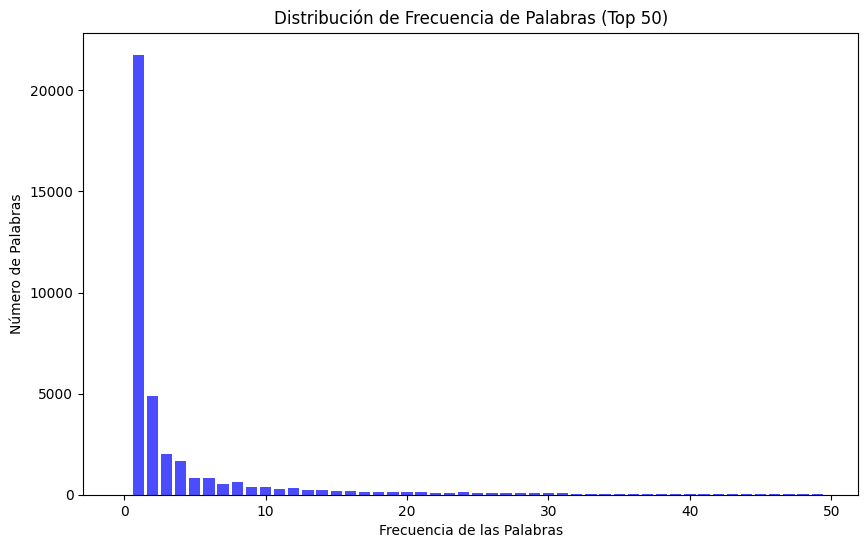

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular la frecuencia de palabras
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
freq_distribution = np.bincount(word_counts)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.bar(range(len(freq_distribution[:50])), freq_distribution[:50], color='blue', alpha=0.7)
plt.title('Distribución de Frecuencia de Palabras (Top 50)')
plt.xlabel('Frecuencia de las Palabras')
plt.ylabel('Número de Palabras')
plt.show()

#### Inspección y Ajuste de alpha

In [156]:
# Distribución de las etiquetas
label_distribution = y_train_with_title.value_counts()
print(label_distribution)

storypoint
3     1465
5     1378
1     1298
2     1005
8      829
4      134
13     128
20      24
10      21
6       14
16       7
40       5
12       4
7        2
15       2
21       2
34       1
32       1
Name: count, dtype: int64


### Busqueda del mejor modelo

In [118]:
# Vectorizador y modelo en pipeline
pipeline_NB_Tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())
])


In [119]:
# # Definir el rango de hiperparámetros
# param_grid = {
#     'vectorizer__max_features': [1000, 2000, 5000],
#     'vectorizer__ngram_range': [(1, 1), (1, 2)],
#     'vectorizer__min_df': [2, 5],
#     'vectorizer__max_df': [0.5, 0.75],
#     'classifier__alpha': [0.1, 0.5, 1.0, 2.0]
# }

In [120]:
# Ajustar hiperparámetros para reducir sobreajuste
param_grid = {
    'vectorizer__max_features': [1000, 2000, 3000, 5000],  # Reducir características
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],     # Incluir bigramas opcionalmente
    'vectorizer__min_df': [1, 2, 5, 10],                   # Incrementar frecuencia mínima
    # 'vectorizer__max_df': [0.4, 0.5],                # Reducir frecuencia máxima
    'classifier__alpha': [1.0, 2.0, 3.0, 4.0]             # Mayor regularización
}

#### Sin titulo y con Tfidf

In [121]:
# Definir métrica personalizada para RMSE (negativo porque GridSearchCV maximiza el score)
scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [122]:
# Búsqueda de hiperparámetros
grid_search_NB_Tfidf_without_title = GridSearchCV(pipeline_NB_Tfidf, param_grid, cv=5, scoring=scorer, verbose=2, n_jobs=-1)
grid_search_NB_Tfidf_without_title.fit(X_train_without_title, y_train_without_title)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [1.0, 2.0, 3.0, 4.0],
                         'vectorizer__max_features': [1000, 2000, 3000, 5000],
                         'vectorizer__min_df': [5, 10],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict', squared=False),
             verbose=2)

In [123]:
# Obtener el mejor modelo
best_model_NB_Tfidf_without_title = grid_search_NB_Tfidf_without_title.best_estimator_
print("Mejores hiperparámetros de grid_search_NB_Tfidf_without_title:", grid_search_NB_Tfidf_without_title.best_params_)

Mejores hiperparámetros de grid_search_NB_Tfidf_without_title: {'classifier__alpha': 4.0, 'vectorizer__max_features': 5000, 'vectorizer__min_df': 5, 'vectorizer__ngram_range': (1, 1)}


In [124]:
# Predecir directamente usando el pipeline completo
y_val_Tfidf_without_title_pred = best_model_NB_Tfidf_without_title.predict(X_val_without_title)

In [125]:
rmse_Tfidf_without_title = mean_squared_error(y_val_without_title, y_val_Tfidf_without_title_pred, squared=False)
print(f"RMSE en el conjunto de validación: {rmse_Tfidf_without_title}")

RMSE en el conjunto de validación: 2.72227101767456


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [126]:
joblib.dump(best_model_NB_Tfidf_without_title, 'best_model_NB_Tfidf_without_title.pkl')

['best_model_NB_Tfidf_without_title.pkl']

In [127]:
y_test_without_title_predictions = best_model_NB_Tfidf_without_title.predict(df_test_without_title["description"])

In [128]:
# Guardar las predicciones para submission (si es requerido)
submission_Tfidf_without_title = pd.DataFrame({
    "id": df_test_without_title["id"],  # Ajustar según el formato del archivo test.csv
    "storypoint": y_test_without_title_predictions
})
submission_Tfidf_without_title.to_csv("submission_Tfidf_without_title.csv", index=False)
print("Predicciones guardadas en 'submission_Tfidf_without_title.csv'")

Predicciones guardadas en 'submission_Tfidf_without_title.csv'


#### Con titulo y con Tfidf

In [129]:
# Definir métrica personalizada para RMSE (negativo porque GridSearchCV maximiza el score)
scorer_with_title = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [130]:
# Búsqueda de hiperparámetros
grid_search_NB_Tfidf_with_title = GridSearchCV(pipeline_NB_Tfidf, param_grid, cv=5, scoring=scorer, verbose=2, n_jobs=-1)
grid_search_NB_Tfidf_with_title.fit(X_train_with_title, y_train_with_title)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [1.0, 2.0, 3.0, 4.0],
                         'vectorizer__max_features': [1000, 2000, 3000, 5000],
                         'vectorizer__min_df': [5, 10],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict', squared=False),
             verbose=2)

In [131]:
# Obtener el mejor modelo
best_model_NB_Tfidf_with_title = grid_search_NB_Tfidf_with_title.best_estimator_
print("Mejores hiperparámetros de grid_search_NB_Tfidf_with_title:", grid_search_NB_Tfidf_with_title.best_params_)

Mejores hiperparámetros de grid_search_NB_Tfidf_with_title: {'classifier__alpha': 4.0, 'vectorizer__max_features': 5000, 'vectorizer__min_df': 5, 'vectorizer__ngram_range': (1, 1)}


In [132]:
# Predecir directamente usando el pipeline completo
y_val_Tfidf_with_title_pred = best_model_NB_Tfidf_with_title.predict(X_val_with_title)

In [133]:
rmse_Tfidf_with_title = mean_squared_error(y_val_with_title, y_val_Tfidf_with_title_pred, squared=False)
print(f"RMSE en el conjunto de validación: {rmse_Tfidf_with_title}")

RMSE en el conjunto de validación: 2.678441829293926


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [134]:
joblib.dump(best_model_NB_Tfidf_with_title, 'best_model_NB_Tfidf_with_title.pkl')

['best_model_NB_Tfidf_with_title.pkl']

In [135]:
y_test_with_title_predictions = best_model_NB_Tfidf_with_title.predict(df_test_with_title["description"])

In [136]:
# Guardar las predicciones para submission (si es requerido)
submission_Tfidf_with_title = pd.DataFrame({
    "id": df_test_with_title["id"],  # Ajustar según el formato del archivo test.csv
    "storypoint": y_test_with_title_predictions
})
submission_Tfidf_with_title.to_csv("submission_Tfidf_with_title.csv", index=False)
print("Predicciones guardadas en 'submission_Tfidf_with_title.csv'")

Predicciones guardadas en 'submission_Tfidf_with_title.csv'


## Carga del modelo

In [137]:
# # Cargar un modelo y su vectorizador
# model_file = "./model_exports/Vect_1_TF-IDF_sin_lematización_model.pkl"
# vectorizer_file = "./model_exports/Vect_1_TF-IDF_sin_lematización_vectorizer.pkl"

# model = joblib.load(model_file)
# vectorizer = joblib.load(vectorizer_file)

# # Usar el modelo para predecir
# sample_text = ["This is a new user story description."]
# sample_text_vect = vectorizer.transform(sample_text)
# prediction = model.predict(sample_text_vect)

# print(f"Predicción: {prediction}")